
# Lab 1 - Image Processing - Segmentation & Registration




This TP / assignment aims to allow you to explore different segmentation and registration methods.

The data we'll use is from this github : https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md
Which are MRI images of brains.

Documents to submit :
* This notebook with your code and comments.
* A report (pdf format) to present the results of your different methods, how you implemented them, how they work, their differences, their strengths and their weaknesses. You can use LaTex or Typst for your report.

Only one student needs to submit for their group.


Student Name(s) (up to 4 for each group) :


1.   First Name, Last Name, student ID (matricule) :
2.   First Name, Last Name, student ID (matricule) :
3. ...
4.


### **Evaluation**

#### Segmentation (10 points)

Code : 3 points.

Report : 7 points. 3.5 points to present your results. 3.5 points to discuss your methods (how you implemented them, how they work, their differences, their strengths and their weaknesses).

#### Registration (10 points)

Code : 3 points.

Report : 7 points. 3.5 points to present your results. 3.5 points to discuss your methods (how you implemented them, how they work, their differences, their strengths and their weaknesses).

**Total : 20 points.**



### import libraries

In [8]:
import os
import tarfile
import urllib.request
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform

### Data preparation

Extracting example data...
Data ready in 'student_data/'. Files: image.nii.gz, seg.nii.gz


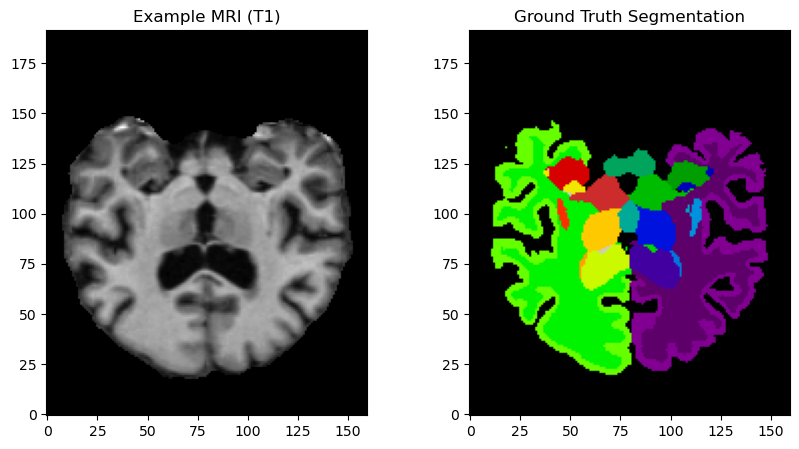

In [9]:

# 1. Download the lightweight 2D Neurite-OASIS dataset (approx 24MB)
url = "https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar"
tar_path = "neurite-oasis.2d.v1.0.tar"

if not os.path.exists(tar_path):
    print("Downloading dataset (24MB)...")
    urllib.request.urlretrieve(url, tar_path)
    print("Download complete.")

# 2. Extract one specific subject to serve as the example
# We will use subject 'OASIS_OAS1_0001_MR1'
subject_id = "OASIS_OAS1_0001_MR1"
output_dir = "student_data"
os.makedirs(output_dir, exist_ok=True)

print("Extracting example data...")
with tarfile.open(tar_path, "r") as tar:


    img_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_norm.nii.gz" in m.name][0]
    seg_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_seg24.nii.gz" in m.name][0]

    # Extract and rename for simplicity
    f_img = tar.extractfile(img_member)
    f_seg = tar.extractfile(seg_member)

    with open(os.path.join(output_dir, "image.nii.gz"), "wb") as out:
        out.write(f_img.read())
    with open(os.path.join(output_dir, "seg.nii.gz"), "wb") as out:
        out.write(f_seg.read())

print(f"Data ready in '{output_dir}/'. Files: image.nii.gz, seg.nii.gz")

# 3. Visualize the data
img = nib.load(os.path.join(output_dir, "image.nii.gz")).get_fdata().squeeze()
seg = nib.load(os.path.join(output_dir, "seg.nii.gz")).get_fdata().squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.T, cmap='gray', origin='lower')
plt.title("Example MRI (T1)")
plt.subplot(1, 2, 2)
plt.imshow(seg.T, cmap='nipy_spectral', origin='lower')
plt.title("Ground Truth Segmentation")
plt.show()

In [10]:
# If you want to get access to the other data

subject_ids_in_tar = set()

with tarfile.open(tar_path, "r") as tar:
    for member in tar.getmembers():
        if "slice_norm.nii.gz" in member.name:
            parts = member.name.split('/')
            if len(parts) > 0:
                subject_id = parts[0].split('_data')[0] # Get 'OASIS_OAS1_0001_MR1'
                subject_ids_in_tar.add(subject_id)

print(f"Total unique subjects found in the tar file: {len(subject_ids_in_tar)}")
print("Available Subject IDs:")
for sid in sorted(list(subject_ids_in_tar)): # Sort for consistent output
    print(f"- {sid}")


Total unique subjects found in the tar file: 414
Available Subject IDs:
- OASIS_OAS1_0001_MR1
- OASIS_OAS1_0002_MR1
- OASIS_OAS1_0003_MR1
- OASIS_OAS1_0004_MR1
- OASIS_OAS1_0005_MR1
- OASIS_OAS1_0006_MR1
- OASIS_OAS1_0007_MR1
- OASIS_OAS1_0009_MR1
- OASIS_OAS1_0010_MR1
- OASIS_OAS1_0011_MR1
- OASIS_OAS1_0012_MR1
- OASIS_OAS1_0013_MR1
- OASIS_OAS1_0014_MR1
- OASIS_OAS1_0015_MR1
- OASIS_OAS1_0016_MR1
- OASIS_OAS1_0017_MR1
- OASIS_OAS1_0018_MR1
- OASIS_OAS1_0019_MR1
- OASIS_OAS1_0020_MR1
- OASIS_OAS1_0021_MR1
- OASIS_OAS1_0022_MR1
- OASIS_OAS1_0023_MR1
- OASIS_OAS1_0025_MR1
- OASIS_OAS1_0026_MR1
- OASIS_OAS1_0027_MR1
- OASIS_OAS1_0028_MR1
- OASIS_OAS1_0029_MR1
- OASIS_OAS1_0030_MR1
- OASIS_OAS1_0031_MR1
- OASIS_OAS1_0032_MR1
- OASIS_OAS1_0033_MR1
- OASIS_OAS1_0034_MR1
- OASIS_OAS1_0035_MR1
- OASIS_OAS1_0037_MR1
- OASIS_OAS1_0038_MR1
- OASIS_OAS1_0039_MR1
- OASIS_OAS1_0040_MR1
- OASIS_OAS1_0041_MR1
- OASIS_OAS1_0042_MR1
- OASIS_OAS1_0043_MR1
- OASIS_OAS1_0044_MR1
- OASIS_OAS1_0045_MR1
- OA

# Segmentation

This code provides you a segmentation with 4 classes.

Data ready in 'student_data/'. Files: image.nii.gz, seg.nii.gz


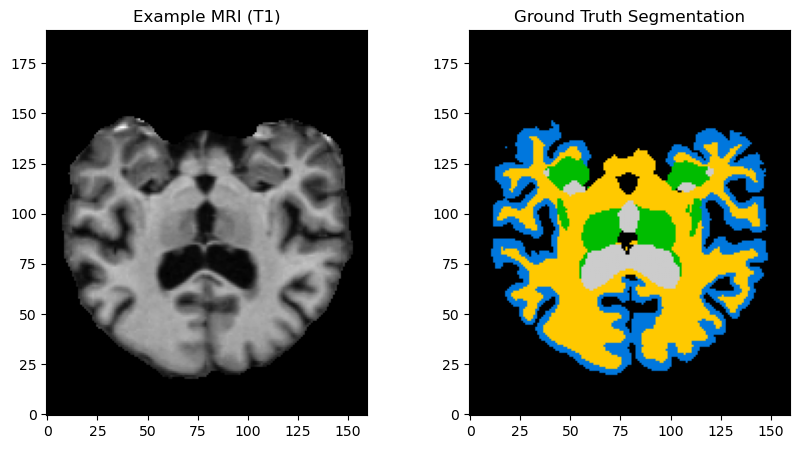

(160, 192)

In [11]:
subject_id = "OASIS_OAS1_0001_MR1"
output_dir = "student_data"
os.makedirs(output_dir, exist_ok=True)

with tarfile.open(tar_path, "r") as tar:
    img_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_norm.nii.gz" in m.name][0]
    seg_member = [m for m in tar.getmembers() if subject_id in m.name and "slice_seg4.nii.gz" in m.name][0]

    # Extract and rename for simplicity
    f_img = tar.extractfile(img_member)
    f_seg = tar.extractfile(seg_member)

    with open(os.path.join(output_dir, "image.nii.gz"), "wb") as out:
        out.write(f_img.read())
    with open(os.path.join(output_dir, "seg.nii.gz"), "wb") as out:
        out.write(f_seg.read())

print(f"Data ready in '{output_dir}/'. Files: image.nii.gz, seg.nii.gz")

# 3. Visualize the data
img = nib.load(os.path.join(output_dir, "image.nii.gz")).get_fdata().squeeze()
seg = nib.load(os.path.join(output_dir, "seg.nii.gz")).get_fdata().squeeze()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.T, cmap='gray', origin='lower')
plt.title("Example MRI (T1)")
plt.subplot(1, 2, 2)
plt.imshow(seg.T, cmap='nipy_spectral', origin='lower')
plt.title("Ground Truth Segmentation")
plt.show()

img.shape

There are plenty of classes for the segmentation. You can do a simpler segmentation where you have 4 labels (instead of 24). It's up to you.

## Methods

You have to do a segmentation of the previous image showed.
You need to use 2 different methods. Explain the differences between these methods.

### List of possible methods (you can use other methods!) :

#### Multi-Otsu Thresholding

* [Reference](https://ieeexplore.ieee.org/document/4310076)

* [Python implementation](https://scikit-image.org/docs/0.25.x/auto_examples/segmentation/plot_multiotsu.html)
####   Gaussian Mixture Models (GMM)

* [Reference](https://towardsdatascience.com/gaussian-mixture-models-gmms-from-theory-to-implementation-4406c7fe9847/)

* [Python implementation](https://scikit-learn.org/stable/modules/mixture.html)
####   U-Net (Deep Learning)
* [Reference](https://arxiv.org/abs/1505.04597)
* Python implementation : use Pytorch

#### Random Walker
* [Reference](https://ieeexplore.ieee.org/document/1704833)
* [Python implementation](https://scikit-image.org/docs/0.25.x/auto_examples/segmentation/plot_random_walker_segmentation.html)



### Method 1

In [12]:
from skimage.filters import threshold_multiotsu
import numpy as np


threshold = threshold_multiotsu(img, classes=5)
regions = np.digitize(img, bins=threshold)

# plt.imshow(regions)

np.unique(regions)


array([0, 1, 2, 3, 4])

In [ ]:
import torch
import numpy as np
import json
import tqdm
from skimage.filters import threshold_multiotsu
from monai.metrics import DiceMetric
from monai.networks.utils import one_hot
from monai.transforms import Compose, ResizeD, ScaleIntensityRanged, EnsureTyped, SpatialCropD
from torch.utils.data import DataLoader

# Use your existing utils and dataset classes
from unet_mri_utils import BrainMRIDataset, MergeSegLabels, AddChannelDim

# --- Setup ---
type_label = "4labels" 
num_classes = 5 if type_label == "4labels" else 3
labels_file_path = "/home/boadem/Work/School/neurite_data/seg4_labels.txt"
test_set_path = "/home/boadem/Work/School/test_set_paths.json"

test_set = json.load(open(test_set_path))

test_transforms = Compose([
    AddChannelDim(keys=["image", "label"]),
    MergeSegLabels(keys=["label"], labels_file_path=labels_file_path, type=type_label),
    SpatialCropD(keys=["image", "label"], roi_start=(0, 0), roi_end=(160, 160)),
    ResizeD(keys=["image", "label"], spatial_size=(128,128), mode=("bilinear", "nearest")),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=255, b_min=0.0, b_max=1.0),
    EnsureTyped(keys=["image", "label"], dtype=(torch.float32, torch.int64)),
])

test_dataset = BrainMRIDataset(
    img_paths=[item["image"] for item in test_set],
    seg_paths=[item["segmentation"] for item in test_set],
    transform=test_transforms
)

# Using batch_size=1 makes it easier to process individual volumes with Otsu
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def test_multi_otsu(loader, num_classes):
    # reduction="mean_batch" preserves the per-class scores
    dice_metric = DiceMetric(include_background=False, reduction="mean_batch")

    print(f"Starting Multi-Otsu evaluation for {num_classes} classes...")

    for batch_data in tqdm.tqdm(loader):
        inputs = batch_data["image"].numpy().squeeze() 
        labels = batch_data["label"]

        # Apply Multi-Otsu
        try:
            # Multi-Otsu needs (classes - 1) thresholds
            thresholds = threshold_multiotsu(inputs, classes=num_classes)
            regions = np.digitize(inputs, bins=thresholds)
        except ValueError:
            # Fallback if image intensity is too uniform
            regions = np.zeros_like(inputs)

        # Convert back to tensors for MONAI metric [B, C, H, W]
        # We add the channel dimension back to match one_hot expectations
        preds_tensor = torch.from_numpy(regions).long().unsqueeze(0).unsqueeze(0)
        
        # One-hot encode
        preds_one_hot = one_hot(preds_tensor, num_classes=num_classes)
        labels_one_hot = one_hot(labels, num_classes=num_classes)
        
        dice_metric(y_pred=preds_one_hot, y=labels_one_hot)

    # Final Aggregation
    mean_dice_per_class = dice_metric.aggregate().cpu().numpy()
    overall_avg_dice = np.mean(mean_dice_per_class)
    
    dice_metric.reset() 
    return overall_avg_dice, mean_dice_per_class

# --- Execution ---
avg_total, avg_per_class = test_multi_otsu(test_loader, num_classes)

# Log results
print(f"\nMulti-Otsu Results ({type_label}):")
print(f"Overall Average Dice: {avg_total:.4f}")
for i, score in enumerate(avg_per_class):
    print(f"  Class {i} Dice: {score:.4f}")

with open("/home/boadem/Work/School/unet_mri_test_results.txt", "a") as f:
    f.write(f"\n--- Multi-Otsu Results ({type_label}) ---\n")
    f.write(f"Overall Average Dice: {avg_total:.4f}\n")
    for i, score in enumerate(avg_per_class):
        f.write(f"Class {i+1} Dice: {score:.4f}\n")
    f.write("------------------------------------------\n")

Found label IDs: [0, 1, 2, 3, 4]
Starting Multi-Otsu evaluation for 5 classes...


100%|██████████| 83/83 [03:03<00:00,  2.21s/it]


Multi-Otsu Results (4labels):
Overall Average Dice: 0.0991
  Class 0 Dice: 0.0021
  Class 1 Dice: 0.3919
  Class 2 Dice: 0.0024
  Class 3 Dice: 0.0000


In [12]:
test_set_path = "/home/boadem/Work/School/test_set_paths.json"
train_set_path = "/home/boadem/Work/School/train_set_paths.json"

test_set = json.load(open(test_set_path))
train_set = json.load(open(train_set_path))

len(test_set)/(len(train_set) + len(test_set))

0.20048309178743962

### Method 2

### Evaluation and results
Present your results and evaluate them with different metrics (for both methods). You need to use Dice coefficient and you can use other metrics (such as IoU) that you think are relevant. You can present other segmented images from 2D Neurite-OASIS dataset.

## Registration




This section focuses on image registration.  
The next cell provides a fixed image $I_{\text{fixed}}$ and a moving (floating) image $I_{\text{moving}}$.

You are required to implement two different registration methods in order to estimate a transformation $T$ such that:
$$
I_{\text{moving}} \circ T \approx I_{\text{fixed}}.
$$


This code creates a rigid transformation.

Generating Synthetic Data: Rotation=-13.26°, Shift=(0.73, 0.20)


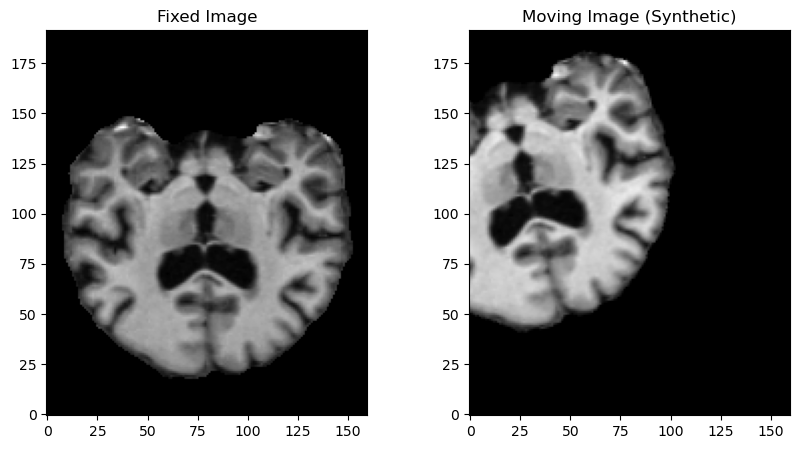

In [14]:
# rigid transformation
# np.random.seed(42)
def create_synthetic_moving_data(fixed_img, fixed_seg, rotation_range=15, shift_range=1):
    """
    Creates a 'Moving' image by applying a random affine transform
    (rotation + translation) to the Fixed image.
    """
    # 1. Generate random parameters
    angle_deg = np.random.uniform(-rotation_range, rotation_range)
    shift_y = np.random.uniform(-shift_range, shift_range)
    shift_x = np.random.uniform(-shift_range, shift_range)

    print(f"Generating Synthetic Data: Rotation={angle_deg:.2f}°, Shift=({shift_y:.2f}, {shift_x:.2f})")

    # 2. Define the Affine Matrix (Inverse mapping is usually required for scipy)
    # Convert to radians
    theta = np.radians(angle_deg)
    c, s = np.cos(theta), np.sin(theta)

    # Rotation matrix (centered usually requires offset handling,
    # but for simple tasks, direct matrix application is often sufficient
    # if we ignore center-of-rotation artifacts or handle them via 'offset')

    # To rotate around center, we often shift center to origin -> rotate -> shift back.
    # Here we simplify:
    center = np.array(fixed_img.shape) / 2.0
    rotation_mat = np.array([[c, -s], [s, c]])
    offset = center - center.dot(rotation_mat) + np.array([shift_y, shift_x])

   

    # 3. Apply transformation
    # We use spline interpolation (order=1) for the image
    moving_img = affine_transform(
        fixed_img,
        matrix=rotation_mat,
        offset=offset,
        order=1,
        mode='constant'
    )

    # We use nearest neighbor (order=0) for the segmentation (labels must remain integers)
    moving_seg = affine_transform(
        fixed_seg,
        matrix=rotation_mat,
        offset=offset,
        order=0,
        mode='constant'
    )

    return moving_img, moving_seg

# --- Usage Example ---
# Create the moving image
moving_img, moving_seg = create_synthetic_moving_data(img, seg)

# Visualize Fixed vs Moving
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.T, cmap='gray', origin='lower')
plt.title("Fixed Image")
plt.subplot(1, 2, 2)
plt.imshow(moving_img.T, cmap='gray', origin='lower')
plt.title("Moving Image (Synthetic)")
plt.show()

Add a non-rigid transformation to the moving image.

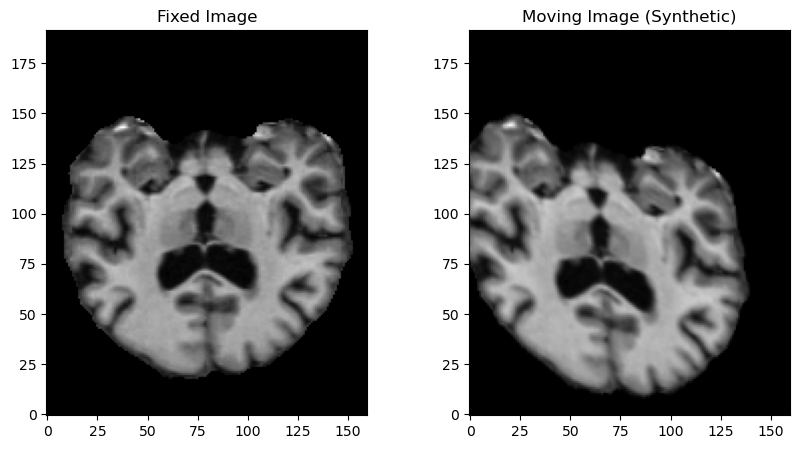

In [ ]:
#Non rigid transform : Skewing along the y-axis
# k = np.random.randn()
k=0.25
skewing_matrix_y = np.array(([1, 0],
                             [k, 1]))
skewed_img = affine_transform(
        moving_img,
        matrix=skewing_matrix_y,
        # offset=,
        order=1,
        mode='constant'
    )


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img.T, cmap='gray', origin='lower')
plt.title("Fixed Image")
plt.subplot(1, 2, 2)
plt.imshow(skewed_img.T, cmap='gray', origin='lower')
plt.title("Moving Image (Synthetic)")
plt.show()

Now, implement 2 different methods of registration

### List of possible methods (you can use other methods!) :

#### Phase Correlation / Fourier Shift Theorem
* [Reference](https://en.wikipedia.org/wiki/Phase_correlation)
* [Python implementation](https://scikit-image.org/docs/stable/api/skimage.registration.html)

#### Mutual Information Maximization
* [Reference](https://link.springer.com/article/10.1023/A:1007958904918)
* [Python implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) (requires coding the MI loss function)

#### VoxelMorph
* [Reference](https://arxiv.org/abs/1809.05231)
* [Python implementation](https://github.com/voxelmorph/voxelmorph)

#### B-Spline Free Form Deformation
* [Reference](https://ieeexplore.ieee.org/document/796284)
* [Python implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.html)



### Method 1

In [37]:
#Phase Correlation

from skimage.registration import optical_flow_tvl1
import torch
import sys
sys.path.append("/home/boadem/Work/")
import voxelmorph_mri_utils as utils
import matplotlib.pyplot as plt
import json
import nibabel as nib
import numpy as np
from monai.transforms import (Compose,
    EnsureChannelFirstd,
    ResizeD)

test_set = json.load(open("/home/boadem/Work/School/test_set_paths.json"))
num_classes = 3
labels_file_path = "/home/boadem/Work/School/neurite_data/seg24_labels.txt"
ckpt_path = "/home/boadem/Work/School/Vxm_brain_mri_models_3labels/best_vxm_fold_5.ckpt"

sample = test_set[0]
image_path, seg_path = sample["image"], sample["segmentation"]
fixed = nib.load(image_path).get_fdata().squeeze()
seg = nib.load(seg_path).get_fdata().squeeze()
transform = Compose([
                EnsureChannelFirstd(keys=["fixed", "moving", "fixed_seg", "moving_seg"], channel_dim="no_channel"),        
                utils.MergeSegLabels(keys=["fixed_seg","moving_seg"], labels_file_path=labels_file_path, num_classes=num_classes),
                ResizeD(keys=["fixed", "moving", "fixed_seg", "moving_seg"], spatial_size=(128,128), mode=("bilinear", "bilinear", "nearest", "nearest")),
                # ScaleIntensityRanged(keys=["fixed", "moving"], a_min=0, a_max=255, b_min=0.0, b_max=1.0)
            ])

moving, moving_seg = utils.create_synthetic_moving_data_nonrigid(fixed, seg, alpha=15, sigma=3.5, kx=0.08, ky=0.1)
moving, moving_seg = utils.rigid_register_2d(fixed=fixed, moving=moving, moving_seg=moving_seg)
fixed_or, moving_or, moving_seg_or = fixed.copy(), moving.copy(), moving_seg.copy()

sample = {"fixed" : fixed.astype(np.float32), "moving" : moving.astype(np.float32), 
                   "fixed_seg" : seg.astype(np.int64), 
                   "moving_seg" : moving_seg.astype(np.int64)                     
                  }
sample = transform(sample)
fixed, moving, fixed_seg, moving_seg = sample["fixed"], sample["moving"], sample["fixed_seg"], sample["moving_seg"]

fixed, moving = fixed.squeeze(), moving.squeeze()
# moved, flow, warped_seg = run_inference(ckpt_path=ckpt_path, fixed_img=fixed, moving_img=moving, moving_seg=moving_seg)
# fixed = fixed.squeeze()
# fixed_seg = fixed_seg.squeeze()
# warped_seg = warped_seg.cpu()


print(type(fixed))




Found GM IDs: [2, 5, 6, 7, 8, 11, 15, 18, 19, 20, 21, 22]
Found WM IDs: [1, 14]
Generating Non-Rigid Synthetic Data: alpha=15, sigma=3.5
<class 'monai.data.meta_tensor.MetaTensor'>


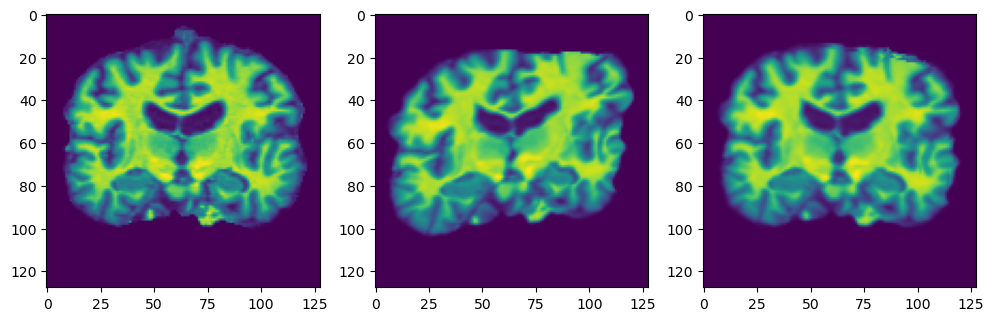

In [38]:
from skimage.registration import optical_flow_tvl1
from skimage.transform import warp


v, u = optical_flow_tvl1(reference_image = fixed, moving_image=moving)  

nr, nc = fixed.shape

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')

warped = warp(moving, np.array([row_coords + v, col_coords + u]), mode='edge')

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(fixed.T)

plt.subplot(132)
plt.imshow(moving.T)

plt.subplot(133)
plt.imshow(warped.T)


### Method 2

Present the results and evaluate them using multiple metrics for both methods. Report the Dice coefficient and, where appropriate, include other relevant measures (for example, Intersection over Union — IoU). Additionally, you may present other registration examples to illustrate the effectiveness of your methods.